In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

     |████████████████████████████████| 16.7MB 3.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 27.2MB 1.4MB/s 
     |████████████████████████████████| 51kB 44.0MB/s 
     |████████████████████████████████| 1.6MB 41.2MB/s 
     |████████████████████████████████| 81kB 47.6MB/s 
     |████████████████████████████████| 1.0MB 46.7MB/s 
     |████████████████████████████████| 61kB 48.6MB/s 
     |████████████████████████████████| 2.7MB 41.5MB/s 
  Created wheel for pycbc: filename=PyCBC-1.16.8-cp36-cp36m-linux_x86_64.whl size=5697429 sha256=8696a94669c47af904e97314ffd0b6245c6025530726ca369508942718f16f35
  Stored in directory: /tmp/pip-ephem-wheel-cache-6gclxi3f/wheels/3f/f6/fe/9944e8a6c8ff5ea38e0d47c4d86feb1176179c64188936aed0
Successfully built pycbc
  Created wheel for ligo-segments: filename=ligo_segments-1.2.0-cp36-cp36m-linux_x86_64.whl size=83609 sha256=f1f162

In [5]:
!git clone https://github.com/marcin119a/lstm-pycbc.git
%cd lstm-pycbc

Cloning into 'lstm-pycbc'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.
/content/lstm-pycbc


In [6]:
from generator_waveform import generate_wave
import pylab 

apx = 'SEOBNRv4'

params = {
    'approximant':apx,
    'mass1':10,
    'mass2':10,
    'spin1z':0.9,
    'spin2z':0.4,
    'inclination':1.23,
    'coa_phase':2.45,
    'delta_t':1.0/4096,
    'f_lower':40
}
ts, signal_l1, signal_v1 = generate_wave(params)

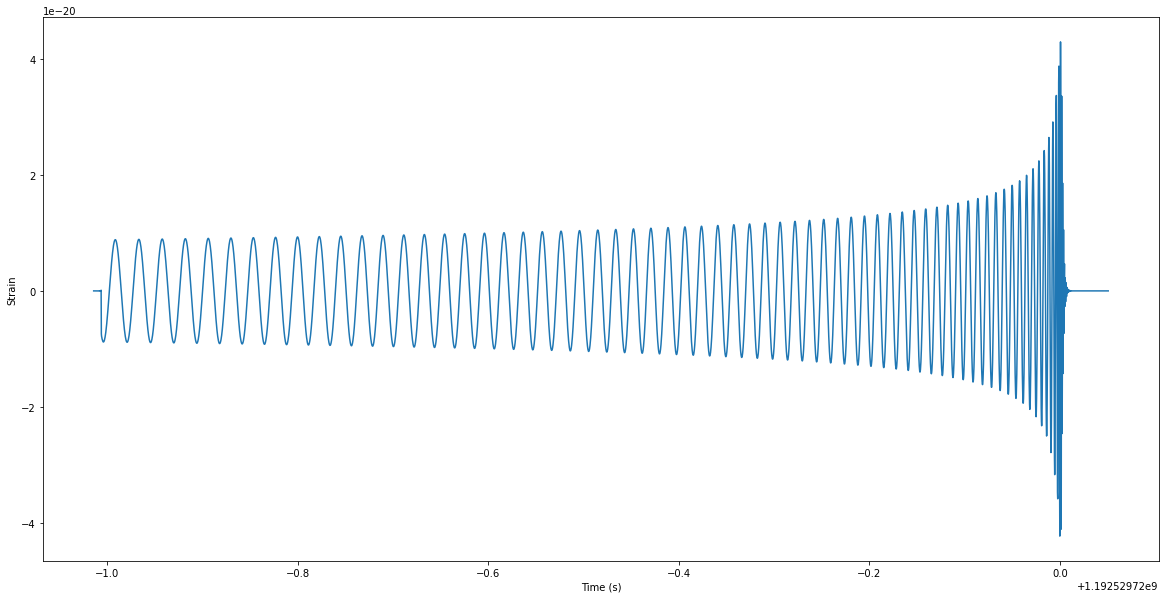

In [7]:
# We can directly plot the time series as follows
pylab.figure(figsize=(20,10))
pylab.plot(ts.sample_times, ts)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

In [9]:
# We can directly plot the time series as follows
from sklearn.preprocessing import MinMaxScaler
import numpy as np 

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = np.array([i for i in ts])
dataset = scaler.fit_transform(dataset.reshape(-1,1))

In [10]:
# reshape into X=t(current and Y=t+1(future)
from utilities import create_dataset, split_dataset

look_back = 3
train, test = split_dataset(dataset)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [sample, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [67]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back:i+2 + look_back, 0])
	return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(train, look_back)


In [68]:
print(trainY)

[[0.49616067 0.49617983]
 [0.49617983 0.49615642]
 [0.49615642 0.4961843 ]
 ...
 [0.35840246 0.35816627]
 [0.35816627 0.35921679]
 [0.35921679 0.36154591]]


Training  for the network is trained for 3 epoch and a batch size of 1 is used



In [69]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
inputs1 = Input(shape=(3, 1))
lstm1, state_h, state_c = LSTM(1, return_state=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2)

Epoch 1/3
2917/2917 - 4s - loss: 0.2802 - lstm_18_loss: 0.0867 - lstm_18_1_loss: 0.0867 - lstm_18_2_loss: 0.1069
Epoch 2/3
2917/2917 - 4s - loss: 0.0260 - lstm_18_loss: 0.0075 - lstm_18_1_loss: 0.0075 - lstm_18_2_loss: 0.0110
Epoch 3/3
2917/2917 - 4s - loss: 0.0133 - lstm_18_loss: 0.0041 - lstm_18_1_loss: 0.0041 - lstm_18_2_loss: 0.0051
